In [2]:
### Loading Credentials from local file; 
### this cell is meant to be deleted before publishing
import yaml

with open("../creds.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

uri = cfg["sonar_creds"]["uri"]
user = cfg["sonar_creds"]["user"]
password = cfg["sonar_creds"]["pass"]

<font size = "20"> SoNAR (IDH) - HNA Curriculum </font>

<font size = "5">Notebook 5:  Example Case - History of Economics</font>

Main Node: Gustav (von) Schmoller

# Who is Gustav von Schmoller?

## What was Schmollers profession? 

In [138]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToTopicTerm]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [139]:
topicterms = [x for x,y in G.nodes(data=True) if y['type']=="TopicTerm"]

for term in topicterms:
    print(G.nodes(data=True)[term]["Name"])

Volkswirt
Wirtschaftswissenschaftler
Sozialwissenschaftler
Hochschullehrer


## What geographic places are connected to Schmoller?

In [140]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToGeoName]-(g:GeoName)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [141]:
place_of_birth = [target for source, target, attribute in G.edges(data=True) if attribute['SourceType'] == 'placeOfBirth']
place_of_death = [target for source, target, attribute in G.edges(data=True) if attribute['SourceType'] == 'placeOfDeath']
places_of_activity = [[source, target] for source, target, attribute in G.edges(data=True) if attribute['SourceType'] == 'placeOfActivity']

# we need to refine the result of the places of activity a little further
# currently there can be the node (2923000) of Schmoller in the results. Therefor we need to filter out the node of him
places_of_activity = [place for sublist in places_of_activity for place in sublist if place != 2923000]

# let's print the results:
print("Place of Birth:", G.nodes(data=True)[place_of_birth[0]]["Name"])
print("Place of Death:",G.nodes(data=True)[place_of_death[0]]["Name"])
print("")
print("Places of Activity:")
for place in places_of_activity:
    print(G.nodes(data=True)[place]["Name"])

Place of Birth: Heilbronn
Place of Death: Bad Harzburg

Places of Activity:
Straßburg
Halle (Saale)
Berlin


## With whom was Schmoller in contact?

In [142]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378" AND rel.SourceType = "correspondedRelation"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [143]:
connections_topic_ids = [x for x,y in G.nodes(data=True) if y['type']=="TopicTerm"]

connections_topic_names = []

for term in connections_topicterms:
    connections_topic_names.append(G.nodes(data=True)[term]["label"])

In [145]:
import pandas as pd

topicterms_df = pd.DataFrame(connections_topic_names, index = connections_topic_ids, columns = ["topic"])

degree_list = []
for topic in connections_topic_names:
    degree_list.append(G.degree(topicterms_df.loc[topicterms_df["topic"] == topic].index[0]))

topicterms_df["degree"] = degree_list
topicterms_df.sort_values("degree", ascending=False)

,topic,degree
51562647,Historiker,14
51562669,Hochschullehrer,13
51565992,Schriftsteller,10
51563092,Jurist,9
51617740,Volkswirt,7
...,...,...
51601402,Kunstsammler,1
51629389,Romanist,1
51689269,Staatswissenschaftler,1
51587285,Botaniker,1


In [175]:
import networkx as nx

historian_term_id = topicterms_df.loc[topicterms_df["topic"] == "Historiker"].index[0]
historians_node_ids = [n for n in G.neighbors(historian_term_id)]

[y["Name"] for x,y in G.nodes(data=True) if x in historians_node_ids]

['Heyck, Eduard',
 'Lamprecht, Karl',
 'Schulte, Aloys',
 'Lang, Wilhelm',
 'Koser, Reinhold',
 'Zeller, Eduard',
 'Schwegler, Albert',
 'Lenz, Max',
 'Hampe, Karl',
 'Gothein, Eberhard',
 'Fechner, Hermann Adolph',
 'Ermisch, Hubert',
 'Brinkmann, Carl',
 'Sybel, Heinrich von']

# What connections does Schmoller have to Berlin Politics?

`TopicTerm Id` for "Politiker" = `(DE-588)4046517-2`

`TopicTerm Id` for "Politikerin" = `(DE-588)4175019-6` 

In [184]:
%%time

from neo4j import GraphDatabase
from helper_functions.helper_fun import to_nx_graph

driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)--(t:TopicTerm)
WHERE t.Id IN ["(DE-588)4046517-2", "(DE-588)4175019-6"] 
WITH DISTINCT [x in collect(n)|id(x)] as collectedIds
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2:RelationToGeoName]-(g:GeoName)
WHERE (n.Id = "(DE-588)118609378") AND (id(n2) IN collectedIds) AND (g.Name CONTAINS "Berlin")
RETURN n, rel, n2
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

CPU times: user 40.9 ms, sys: 9.18 ms, total: 50.1 ms
Wall time: 2.58 s


In [185]:
[y["Name"] for x,y in G.nodes(data=True)]

['Schmoller, Gustav von',
 'Berlepsch, Hans Hermann von',
 'Hoetzsch, Otto',
 'Naumann, Friedrich',
 'Treitschke, Heinrich von',
 'Liszt, Franz von',
 'Duncker, Maximilian Wolfgang',
 'Braun, Heinrich',
 'Bismarck, Otto von',
 'Droysen, Johann Gustav',
 'Delbrück, Hans',
 'Schmidt-Ott, Friedrich',
 'Thiel, Hugo',
 'Münsterberg, Emil',
 'Arendt, Otto',
 'Borght, Richard van der']

In [193]:
[(G.nodes(data=True)[target]["Name"], attribute["SourceType"]) for source, target, attribute in G.edges(data=True) if attribute['title'] == 'SocialRelation']

[('Berlepsch, Hans Hermann von', 'knows'),
 ('Hoetzsch, Otto', 'knows'),
 ('Naumann, Friedrich', 'knows'),
 ('Treitschke, Heinrich von', 'associatedRelation'),
 ('Liszt, Franz von', 'associatedRelation'),
 ('Duncker, Maximilian Wolfgang', 'associatedRelation'),
 ('Braun, Heinrich', 'knows'),
 ('Bismarck, Otto von', 'associatedRelation'),
 ('Droysen, Johann Gustav', 'knows'),
 ('Delbrück, Hans', 'associatedRelation'),
 ('Schmidt-Ott, Friedrich', 'correspondedRelation'),
 ('Thiel, Hugo', 'associatedRelation'),
 ('Münsterberg, Emil', 'associatedRelation'),
 ('Arendt, Otto', 'knows'),
 ('Borght, Richard van der', 'knows')]

In [186]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

nt = Network('750px', '100%', notebook=True, directed = True)
nt.from_nx(G)
nt.set_edge_smooth("dynamic")
nt.show('./html_networks/schmoller_politics_first_lvl.html')

# Who was graduated as PhD by Schmoller?

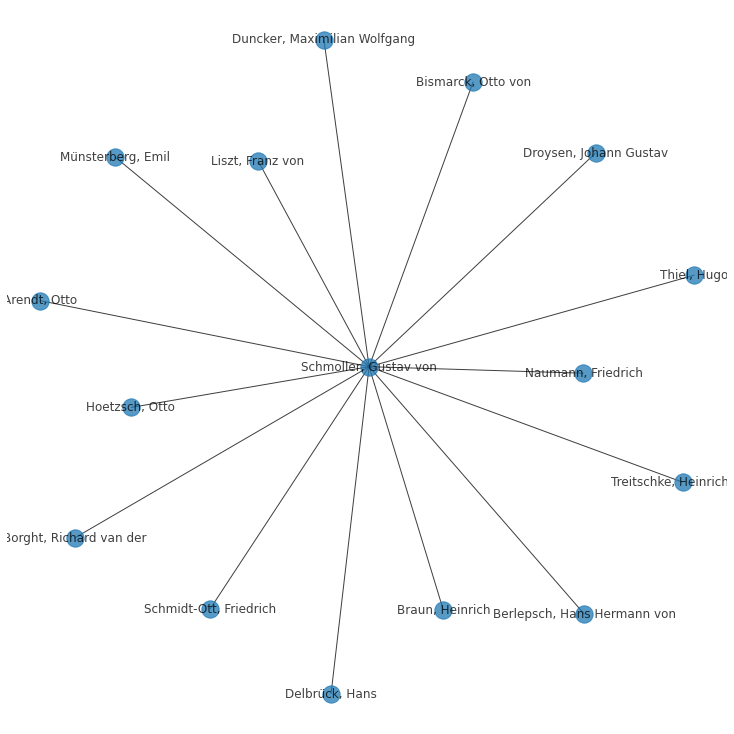

In [222]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
labels = nx.get_node_attributes(G, "Name")

nx.draw(G, labels = labels, alpha = 0.75)


In [223]:
driver = GraphDatabase.driver(uri, auth=(user, password))

Id = "(DE-588)118609378"

query = """
 MATCH (n:PerName)
 WHERE n.Id = $Id
 RETURN n
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)
G.nodes(data=True)

ClientError: {code: Neo.ClientError.Statement.ParameterMissing} {message: Expected parameter(s): Id}